In [1]:
import os
import cv2

from retina_features.bloodvessels import extract_bv

In [4]:
pathFolder = "data/Sample_imgs/TV"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
destinationFolder = "data/Sample_imgs/TV_processed/"

In [5]:
for file_name in filesArray:
    file_name_no_extension = os.path.splitext(file_name)[0]
    fundus = cv2.imread(pathFolder + '/' + file_name)		
    bloodvessel = extract_bv(fundus)
    cv2.imwrite(destinationFolder + file_name_no_extension + "_bloodvessel.png", bloodvessel)

- 看起來 907 & 1329 最明顯（？
- 用 907 好了

In [1]:
import numpy as np
from skimage.measure import label
from skimage.color import label2rgb
from skimage import io, morphology, filters

from common import plot_image, compare_plots
from tv_processer import TVProcesser

In [2]:
image_path = 'data/Sample_imgs/TV_processed/907_bloodvessel.png'
vessels_image = io.imread(image_path, as_gray=True)

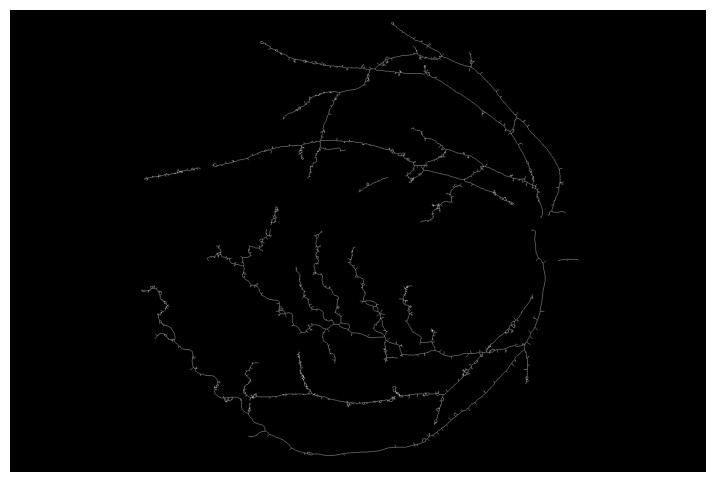

In [3]:
# Binarize the image (assuming the vessels are darker than the background)
# We invert the image because for the skeletonization, we need the vessels in white
binarized_image = vessels_image < np.mean(vessels_image)
skeleton = morphology.skeletonize(binarized_image)
plot_image(skeleton)

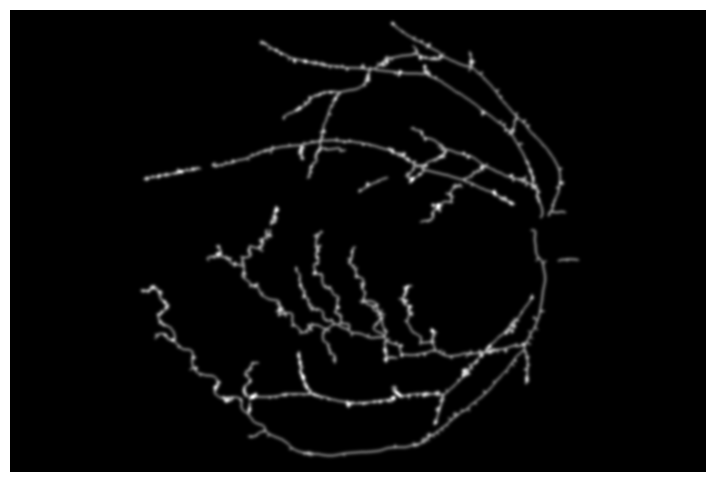

In [4]:
blurred_skeleton = filters.gaussian(skeleton, sigma=5)
plot_image(blurred_skeleton)

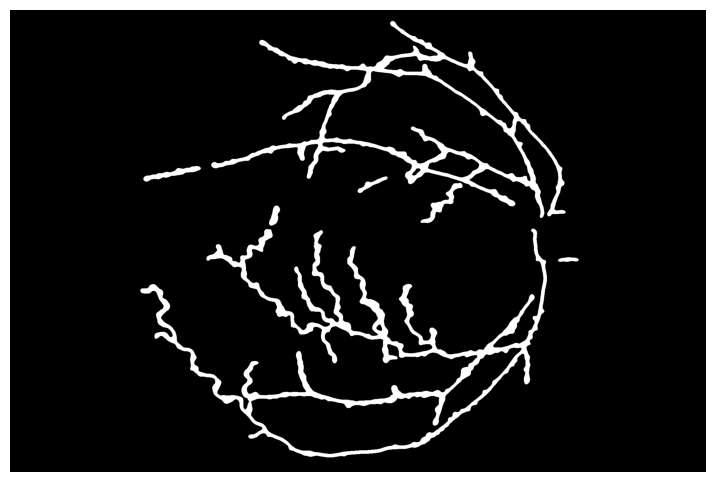

In [5]:
re_threshold_value = filters.threshold_otsu(blurred_skeleton)
re_binarized_skeleton = blurred_skeleton > re_threshold_value
plot_image(re_binarized_skeleton)

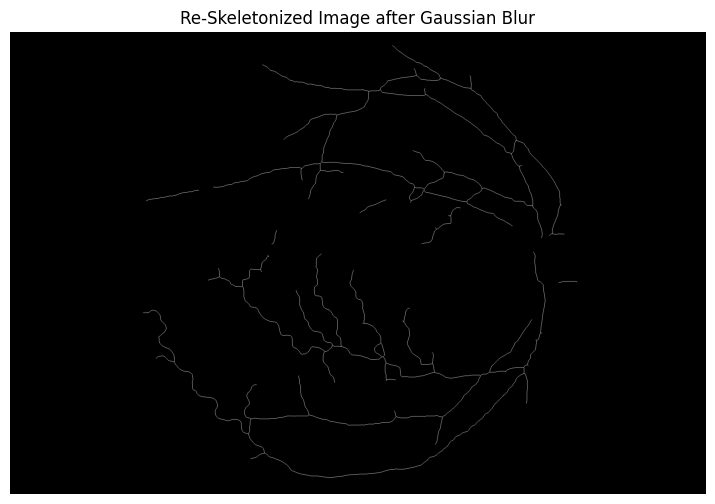

In [6]:
re_skeleton = morphology.skeletonize(re_binarized_skeleton)
plot_image(re_skeleton, "Re-Skeletonized Image after Gaussian Blur")

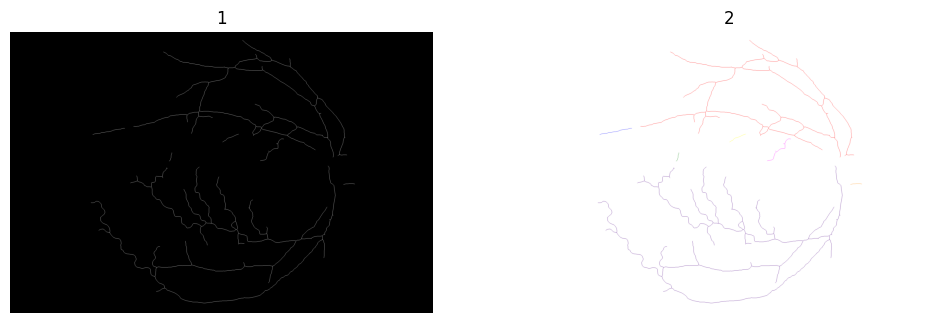

In [7]:
labeled_skeleton = label(re_skeleton)
label_colors = label2rgb(labeled_skeleton, bg_label=0, bg_color=(1, 1, 1))

# Plot the original skeleton and the colored labeled image
compare_plots(re_skeleton, label_colors)

Marking points: 100%|██████████| 5733/5733 [00:00<00:00, 52936.77it/s]


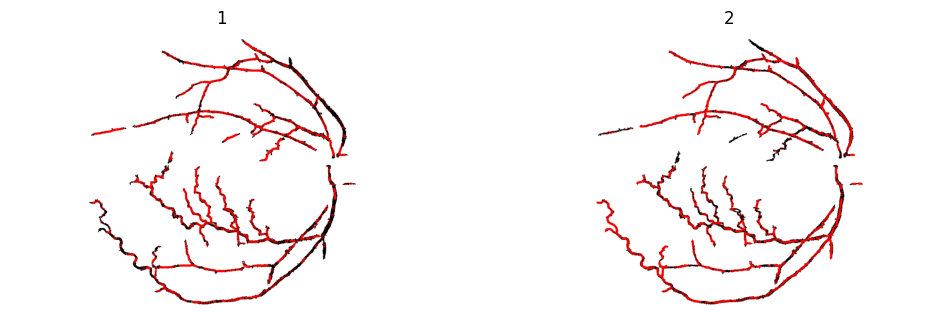

In [10]:
tv_processer = TVProcesser(vessels_image)
curvature_acute_points, curvature_obtuse_points = tv_processer.calculate_curvature(re_skeleton, window_size=10, curvature_threshold=np.pi/4)

marked_acute_image = tv_processer.mark_curvature_points(curvature_acute_points, radius=5, color=(255, 0, 0))
marked_obtuse_image = tv_processer.mark_curvature_points(curvature_obtuse_points, radius=5, color=(255, 0, 0))

compare_plots(marked_acute_image, marked_obtuse_image)

## Validate TVProcesser with Example Lines

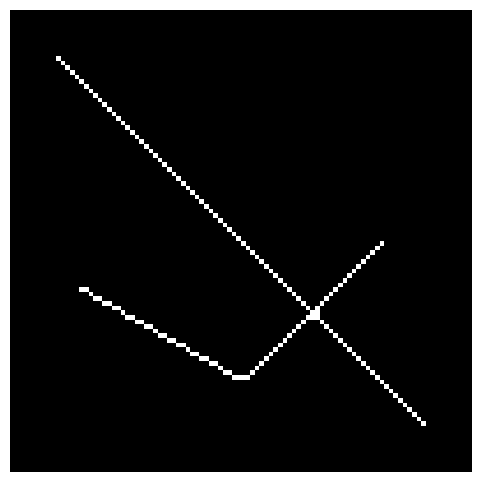

In [8]:
from skimage.draw import line_aa

# Create a synthetic image with a straight line and a curve
synthetic_image = np.zeros((100, 100), dtype=np.uint8)

# Draw a straight line
rr, cc, val = line_aa(10, 10, 90, 90)
synthetic_image[rr, cc] = val * 255

# Draw a curve by connecting two lines at a sharp angle
rr, cc, val = line_aa(60, 15, 80, 50)
synthetic_image[rr, cc] = val * 255
rr, cc, val = line_aa(80, 50, 50, 80)
synthetic_image[rr, cc] = val * 255

# Skeletonize the synthetic image
synthetic_skeleton = morphology.skeletonize(synthetic_image > 0)

plot_image(synthetic_skeleton)

Marking points:   0%|          | 0/65 [00:00<?, ?it/s]

Marking points: 100%|██████████| 62/62 [00:00<00:00, 29567.58it/s]


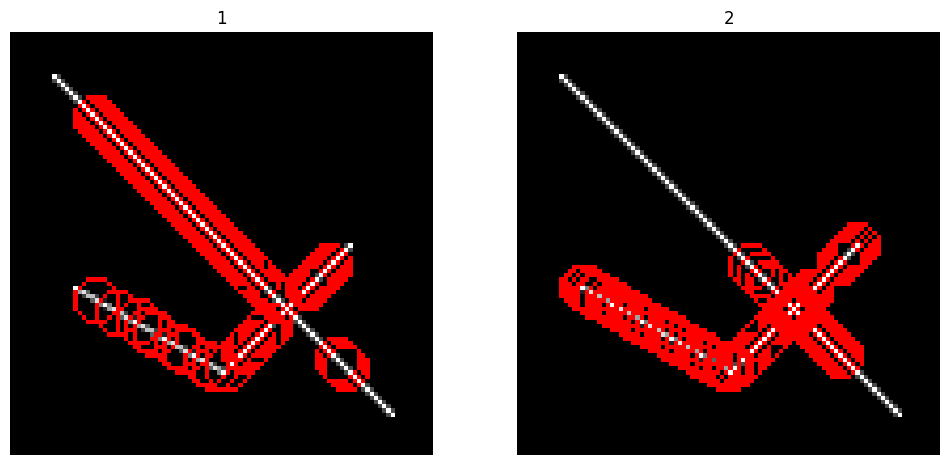

In [9]:
tv_processer = TVProcesser(synthetic_image)
curvature_acute_points, curvature_obtuse_points = tv_processer.calculate_curvature(synthetic_skeleton, window_size=10, curvature_threshold=np.pi/4)

marked_acute_image = tv_processer.mark_curvature_points(curvature_acute_points, radius=5, color=(255, 0, 0))
marked_obtuse_image = tv_processer.mark_curvature_points(curvature_obtuse_points, radius=5, color=(255, 0, 0))

compare_plots(marked_acute_image, marked_obtuse_image)